###### Курсовой проект для курса "Python для Data Science"

###### Материалы к проекту (файлы): train.csv test.csv

## Задание: 
> Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). 
> С помощью полученной модели предсказать цены для квартир из файла test.csv.

##### Целевая переменная: 
* Price

##### Основная метрика: 
* R2 - коэффициент детерминации (sklearn.metrics.r2_score)

##### Вспомогательная метрика: 
* MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

## Сдача проекта: 
>1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook  с расширением ipynb). 
>2. Приложить файл с названием по образцу SShirkin_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

##### Сроки сдачи: 
* Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

##### Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

#####  Подключаем библиотеки.

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['fivethirtyeight'])
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import gmtime

In [2]:
SOURCE_TRAIN_CSV = 'C:/Users/dmitriy.ivanov/Downloads/Kurs_project_task/train.csv'
SOURCE_TEST_CSV = 'C:/Users/dmitriy.ivanov/Downloads/Kurs_project_task/test.csv'
df_train = pd.read_csv(SOURCE_TRAIN_CSV)
df_test = pd.read_csv(SOURCE_TEST_CSV)
filename = 'DmitriyIvanov_pred.csv'

##### Функция межквартильного размаха.

In [3]:
def ir(name):
    a = df_train.loc[df_train[name] > 0,name].describe()
    eps = (a['75%'] - a['25%'])
    i_min = (a['25%'] - 1.5 * eps).astype(int)
    if i_min < 0:
        i_min = 0
    i_max = (a['75%'] + 1.5 * eps).astype(int) + 1
    df_i_range = pd.Series([i_min,i_max])
    return df_i_range

def irt(name):
    a = df_test.loc[df_test[name] > 0,name].describe()
    eps = (a['75%'] - a['25%'])
    i_min = (a['25%'] - 1.5 * eps).astype(int)
    if i_min < 0:
        i_min = 0
    i_max = (a['75%'] + 1.5 * eps).astype(int) + 1
    df_i_range = pd.Series([i_min,i_max])
    return df_i_range

##### Функция графика (повзаимствованная)

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

##### Удалим дубликаты, если таковые имеются.

In [5]:
df_train.drop_duplicates();

##### Установим поле id как индекс и переупорядочим его.

In [6]:
#df_train = df_train.set_index('Id')
#df_train.reset_index(inplace = True, drop = True)
#df_train.index.name = 'id'

##### Проверим наш датасет на null значения.

In [7]:
df_train.isnull().any();

##### Приведем типы

In [8]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

##### Приведем некоторые типы к целым значениям

In [9]:
df_train['Rooms'] = df_train['Rooms'].astype(int)
df_train['HouseFloor'] = df_train['HouseFloor'].astype(int)
df_train['Floor'] = df_train['Floor'].astype(int)
df_train['Id'] = df_train['Id'].astype(int)
df_train['DistrictId'] = df_train['DistrictId'].astype(int)
df_train['HouseYear'] = df_train['HouseYear'].astype(int)

##### Поправим год строительства

In [10]:
x_min_year = ir('HouseYear')[0]
x_max_year = gmtime().tm_year + 1

year_median = df_train.loc[df_train['HouseYear'].apply(lambda x: x <= x_max_year and x >= x_min_year),'HouseYear'].median()

df_train.loc[df_train['HouseYear'].apply(lambda x: x <= x_min_year or x >= x_max_year),'HouseYear'] = year_median

df_train['HouseYear'] = df_train['HouseYear'].astype(int)

### Поправим этажность домов

##### Исправим нулевые этаж

In [11]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] =\
df_train[{'HouseFloor','DistrictId'}].groupby('DistrictId')['HouseFloor'].median()

##### Посчитаем медианную высоту дома в районе

In [12]:
med_house_floor_by_district = df_train.loc[(df_train['Floor'] < df_train['HouseFloor']) |\
                                          (~df_train['HouseFloor'].isnull()), {'HouseFloor','DistrictId'}]\
.groupby('DistrictId')['HouseFloor'].median().astype(int)

In [13]:
qqq = df_train.loc[df_train['HouseFloor'].isnull(),{'HouseFloor','DistrictId'}].\
merge(med_house_floor_by_district, on = 'DistrictId',how='left')['HouseFloor_y'].round().astype(int)

In [14]:
df_train.loc[df_train['HouseFloor'].isnull(),'HouseFloor'] = qqq.values

##### Обработаем выбросы по этажам исползуя межквартильный размах.

In [15]:
hf75 = df_train['HouseFloor'].quantile(.75)
hf25 = df_train['HouseFloor'].quantile(.25)
hf_max = hf75 + 1.5* (hf75-hf25)

df_train.loc[(df_train['HouseFloor'] > hf_max) | (df_train['HouseFloor'] <=0), 'HouseFloor'] =\
int(round(df_train['HouseFloor'].median()))

In [16]:
df_train.loc[(df_train['Floor'] <= 0)] = df_train['Floor'].median()

In [17]:
df_train['HouseFloor'] = df_train['HouseFloor'].astype(int)

###### Проверим где этаж квартиры выше чем этаж дома или отсутствует и установим этаж квартиры не более чем этаж дома

In [18]:
df_train.loc[(df_train['Floor'] > df_train['HouseFloor']) |(df_train['Floor'].isnull()), 'Floor'] =\
df_train['HouseFloor'].apply(lambda x: random.randint(1, x))

##### Поправим выбросы по комнатам 

In [19]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

##### Для начала вычислим медианное значение кол-ва комнат по району и году постройки

In [20]:
filter1 = df_train.loc[~((df_train['Rooms'] == 0) | (df_train['Rooms'] > 6)) ,{'DistrictId','HouseYear','Rooms'}]
filter1 = filter1.groupby(['DistrictId','HouseYear']).median()
a = df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 6),{'DistrictId','HouseYear','Rooms'}]
b = pd.merge(a, filter1, on=['DistrictId','HouseYear'],how='left')

##### Вычислили медианное значение для комнат такого типа

In [21]:
b['Rooms_y'].median()

2.0

##### Проверим, что нет null значений

In [22]:
df_train['Rooms'].isnull().any()

False

##### Изменим неправильные начения на медианные

In [23]:
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 6), 'Rooms'] =\
b['Rooms_y'].median()

##### Разберемся с площадью кухни

In [24]:
x_min_ksquare = ir('KitchenSquare')[0]
x_max_ksquare = ir('KitchenSquare')[1]
x_med_ksquare = df_train['KitchenSquare'].median()

##### Поправим большие значения выходящие за максимальный размах более чем в 2 раза. В нашем случаее размах = 22

In [25]:
df_train.loc[df_train['KitchenSquare'] > x_max_ksquare, 'KitchenSquare'] = x_max_ksquare

##### Посмотрим на площадь кухонь менее 5 метров. Логично пердположить, что таких должно быть немного, но картина другая

In [26]:
df_train.loc[df_train['KitchenSquare'] < 5, 'KitchenSquare'].value_counts()

1.0    2460
0.0     697
4.0      39
3.0      22
2.0       4
Name: KitchenSquare, dtype: int64

##### Поправим все кухни менее 5 метров на медианное значение

In [27]:
df_train.loc[df_train['KitchenSquare'] < 5, 'KitchenSquare'] =\
x_med_ksquare

In [28]:
df_train['KitchenSquare'].describe()

count    10000.000000
mean         7.416600
std          2.373817
min          5.000000
25%          6.000000
50%          6.000000
75%          9.000000
max         22.000000
Name: KitchenSquare, dtype: float64

##### Healthcare_1 Заполним пустые значения медианными и заполним значения которые выходят за размах

In [29]:
x_min_h1 = ir('Healthcare_1')[0]
x_max_h1 = ir('Healthcare_1')[1]

h1_median = df_train.loc[df_train['Healthcare_1'].apply(lambda x: x <= x_max_h1 and x >= x_min_h1),'Healthcare_1'].median()

df_train.loc[df_train['Healthcare_1'].isnull() == True, 'Healthcare_1'] = df_train['Healthcare_1'].median()

df_train.loc[df_train['Healthcare_1'].apply(lambda x: x <= x_min_h1 or x >= x_max_h1),'Healthcare_1'] = h1_median

df_train['Healthcare_1'].median()

900.0

##### Healthcare_2 распределение выглядит  нормальным, менять не будем

In [30]:
df_train['Helthcare_2'].sort_values().value_counts()

0.0    4214
1.0    2183
3.0    1670
2.0    1158
5.0     388
4.0     288
6.0      99
Name: Helthcare_2, dtype: int64

##### Заполним пустые значения жилой площади

In [31]:
med_dif = df_train[~df_train['LifeSquare'].isnull() & ~df_train['Square'].isnull()][{'Square','LifeSquare'}]\
.median()['Square']-\
df_train[~df_train['LifeSquare'].isnull() & ~df_train['Square'].isnull()][{'Square','LifeSquare'}]\
.median()['LifeSquare']

df_train.loc[df_train['LifeSquare'].isnull(),'LifeSquare'] = df_train['Square'] - med_dif

##### Пересчитаем значения для некорректной жилой площади

In [32]:
df_train.loc[(df_train['LifeSquare'] > df_train['Square'] + df_train['KitchenSquare']),'LifeSquare'] =\
df_train['Square'] - df_train['KitchenSquare']

##### Исправим выбросы для общей площади

In [33]:
s25 = df_train['Square'].quantile(.25) 
s75 = df_train['Square'].quantile(.75)
sdiff = s75 - s25
smax = s75 + 1.5*sdiff
smin = s25 - 1.5*sdiff

df_train.loc[df_train['Square']> smax, 'Square'] = df_train['Square'].median()

s25 = df_train['Square'].quantile(.25) 
s75 = df_train['Square'].quantile(.75)
sdiff = s75 - s25
smax = s75 + 1.5*sdiff
smin = s25 - 1.5*sdiff

df_train.loc[df_train['Square'] < smin, 'Square'] = df_train['Square'].median()

##### Удалим явно неправильные данные для площади

In [34]:
p25 = df_train['Price'].quantile(.25) 
p75 = df_train['Price'].quantile(.75)
pdiff = p75 - p25
pmax = p75 + 1.5*pdiff
pmin = p25 - 1.5*pdiff

df_train = df_train.drop(df_train[(df_train['Square'] < smin) & (df_train['Price'] < pmin)].index)
df_train[(df_train['Square'] < smin)] = df_train['Square'].median()

##### Исправим неправильную общую площадь

In [35]:
df_train.loc[(df_train['Square'] < df_train['LifeSquare']), 'Square'] =\
df_train[df_train['LifeSquare'] < df_train['Square']]['Square'].median()

##### Экология

In [36]:
df_train['E_2'] = df_train['Ecology_2'].replace({'A':2, 'B':1})
df_train['E_3'] = df_train['Ecology_3'].replace({'A':2, 'B':1})

##### Магазины

In [37]:
df_train['S_2'] = df_train['Shops_2'].replace({'A':2, 'B':1})

##### Была идея расчитать медианную цену за 1 метр квадратный по району, но медианная цена с учетом площади, этажа и кол-ва комнат показала себя лучше

In [38]:
#med_price_by_district = df_train.groupby(['DistrictId', 'Square', 'Floor', 'Rooms'], as_index=False).agg({'Price':'median'})\
#                        .rename(columns={'Price':'MedPriceByDistrict'})
#med_price_by_district = df_train.groupby(['DistrictId','HouseYear','Rooms'], as_index=False).agg({'Price':'median'})\
#                        .rename(columns={'Price':'MedPriceByDistrict'})

##### Введем еще один категориальный признак размер района, но возможно от него стоит отказаться, т.к. этот признак влияет не существенно.

In [39]:
#district_size = df_train['DistrictId'].value_counts().reset_index()\
#                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
#df_train = df_train.merge(district_size, on='DistrictId', how='left')
#
#df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > df_train['DistrictSize'].median()).astype(int)

##### Добавим наши новые признаки в датасет

In [40]:
#df_train = df_train.merge(med_price_by_district, on=['DistrictId','HouseYear','Rooms'], how='left')

##### Запишем список фичей в переменные

In [41]:
feature_names = ['Id','DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'E_2', 'E_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'S_2']

#new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

##### Определим датафреймы для нашей модели

In [42]:
X = df_train[feature_names] #+ new_feature_names]
y = df_train[target_name]

##### Проверим isnull значение еще раз

In [43]:
df_train.isnull().any()

Id               False
DistrictId       False
Rooms            False
Square           False
LifeSquare       False
KitchenSquare    False
Floor            False
HouseFloor       False
HouseYear        False
Ecology_1        False
Ecology_2        False
Ecology_3        False
Social_1         False
Social_2         False
Social_3         False
Healthcare_1     False
Helthcare_2      False
Shops_1          False
Shops_2          False
Price            False
E_2              False
E_3              False
S_2              False
dtype: bool

##### Посмотрим описание нашего датасета

In [44]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,E_2,E_3,S_2
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888800,54.470394,37.433171,7.416600,7.37720,12.879300,1984.970900,0.118858,24.687000,5352.157400,8.039200,953.472400,1.319500,4.231300,214138.857399,1.009700,1.027500,1.082500
std,4859.01902,43.587592,0.812096,15.433380,20.397648,2.373817,4.96147,6.067653,17.989064,0.119025,17.532614,4006.799803,23.831875,572.146925,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.00000,0.000000,1.000000,16.117154,-1.619274,5.000000,1.00000,1.000000,1934.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028,1.000000,1.000000,1.000000
25%,4169.50000,20.000000,1.000000,42.155156,23.420898,6.000000,3.00000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,8394.50000,36.000000,2.000000,51.877576,33.496579,6.000000,6.00000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,12592.50000,75.000000,2.000000,64.070653,46.415448,9.000000,11.00000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,900.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,16798.00000,209.000000,6.000000,102.032801,638.163193,22.000000,25.00000,29.000000,2019.000000,0.521867,74.000000,19083.000000,141.000000,3300.000000,6.000000,23.000000,633233.466570,2.000000,2.000000,2.000000


##### Обнаружены еще выбросы которые мы не поправили 

In [45]:
df_train.loc[(df_train['LifeSquare'] < 9),'LifeSquare'] = (df_train['Square'].median() - df_train['KitchenSquare'].median())

In [46]:
df_train['Rooms'] = df_train['Rooms'].astype(int)
df_train['HouseFloor'] = df_train['HouseFloor'].astype(int)
df_train['Floor'] = df_train['Floor'].astype(int)
df_train['Id'] = df_train['Id'].astype(int)
df_train['DistrictId'] = df_train['DistrictId'].astype(int)
df_train['HouseYear'] = df_train['HouseYear'].astype(int)

##### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ___ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

##### Обучим нашу модель и посмотрим результаты. Подобрав гипер-параметр глубины дерева остановился на 11, т.к. данное значение показывает наилучший score на кросс-валидационной проверке

Train R2:	0.915
Test R2:	0.717


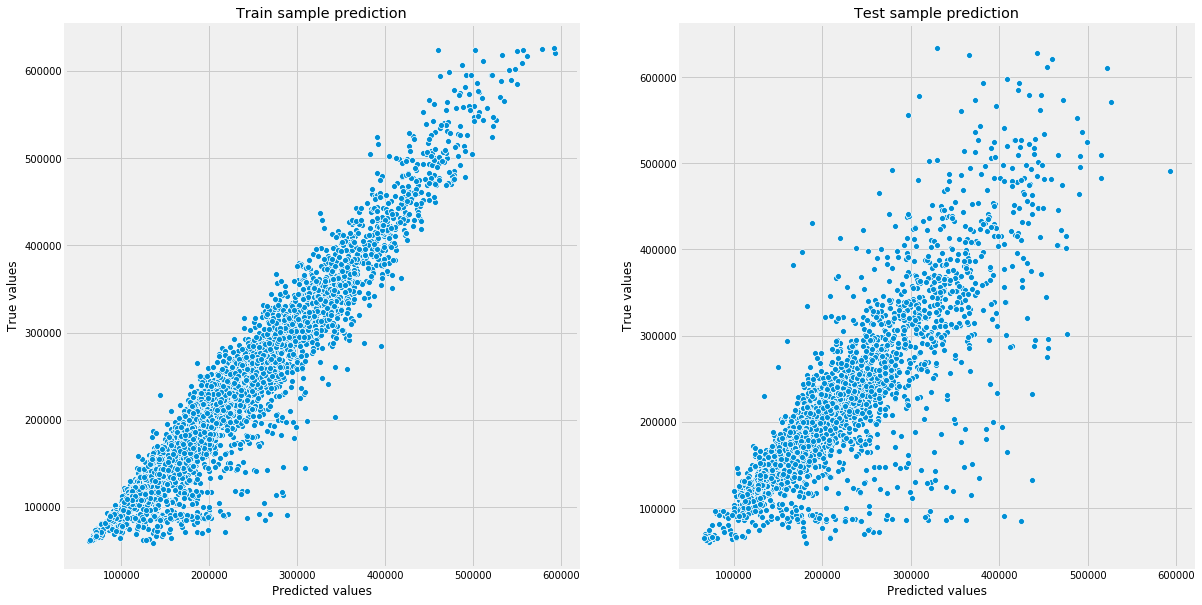

In [47]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

rf_model = RandomForestRegressor(random_state=21, oob_score = True, max_depth = 13, n_estimators = 60)
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

##### Кросс валидация, считаю, что 6 разбиений показвает лучше качество нашей модели чем 3 по умолчание

In [48]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=6, shuffle=True, random_state=21))
cv_score.mean()

0.7140418079354562

##### Важность фичей, как и следовало предположить наша гипер-фича имеет топ 1

In [49]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by = 'importance', ascending = False)

,feature_name,importance
2,Rooms,0.332413
3,Square,0.101532
4,LifeSquare,0.085377
5,KitchenSquare,0.066781
12,Social_1,0.064780
14,Social_3,0.063530
13,Social_2,0.059016
1,DistrictId,0.051285
9,Ecology_1,0.039375
8,HouseYear,0.032823


In [50]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,E_2,E_3,S_2
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,7976.0,5.0,900.0,0.0,11.0,B,184966.930730,1,1,1
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,10309.0,1.0,240.0,1.0,16.0,B,300009.450063,1,1,1
2,4765,53,2,44.947953,29.197612,6.0,8,12,1968,0.049637,...,7759.0,0.0,229.0,1.0,3.0,B,220925.908524,1,1,1
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,5735.0,3.0,1084.0,0.0,5.0,B,175616.227217,1,1,1
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,5776.0,1.0,2078.0,2.0,4.0,B,150226.531644,1,1,1


### Прогнозирование на тестовом датасете

> 1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
> 2. Не потерять и не перемешать индексы от примеров при построении прогнозов
> 3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [51]:
df_test.head().sort_values(by = 'Id', ascending = True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B


##### Применим все наши трансформации для тестового датасета

In [52]:
df_test['Rooms'] = df_test['Rooms'].astype(int)
df_test['HouseFloor'] = df_test['HouseFloor'].astype(int)
df_test['Floor'] = df_test['Floor'].astype(int)
df_test['Id'] = df_test['Id'].astype(int)
df_test['DistrictId'] = df_test['DistrictId'].astype(int)
df_test['HouseYear'] = df_test['HouseYear'].astype(int)

In [53]:
x_min_year = irt('HouseYear')[0]
x_max_year = gmtime().tm_year + 1

year_median = df_test.loc[df_train['HouseYear'].apply(lambda x: x <= x_max_year and x >= x_min_year),'HouseYear'].median()

df_test.loc[df_test['HouseYear'].apply(lambda x: x <= x_min_year or x >= x_max_year),'HouseYear'] = year_median

df_test['HouseYear'] = df_test['HouseYear'].astype(int)

In [54]:
df_test.loc[df_test['HouseFloor'] == 0, 'HouseFloor'] =\
df_test[{'HouseFloor','DistrictId'}].groupby('DistrictId')['HouseFloor'].median()

In [55]:
med_house_floor_by_district_test = df_test.loc[(df_test['Floor'] < df_test['HouseFloor']) |\
                                          (~df_test['HouseFloor'].isnull()), {'HouseFloor','DistrictId'}]\
.groupby('DistrictId')['HouseFloor'].median().astype(int)

In [56]:
qq = df_test.loc[df_test['HouseFloor'].isnull(),{'HouseFloor','DistrictId'}].\
merge(med_house_floor_by_district_test, on = 'DistrictId',how='left')['HouseFloor_y'].round().astype(int)

In [57]:
df_test.loc[df_test['HouseFloor'].isnull(),{'HouseFloor'}] = qq.values

In [58]:
hf75 = df_test['HouseFloor'].quantile(.75)
hf25 = df_test['HouseFloor'].quantile(.25)
hf_max = hf75 + 1.5* (hf75-hf25)

df_test.loc[(df_test['HouseFloor'] > hf_max) | (df_test['HouseFloor'] <=0), 'HouseFloor'] =\
int(round(df_test['HouseFloor'].median()))

In [59]:
df_test.loc[(df_test['Floor'] <= 0)] = df_test['Floor'].median()

In [60]:
df_test['HouseFloor'] = df_test['HouseFloor'].astype(int)

In [61]:
df_test.loc[(df_test['Floor'] > df_test['HouseFloor']) |(df_test['Floor'].isnull()), 'Floor'] =\
df_test['HouseFloor'].apply(lambda x: random.randint(1, x))

In [62]:
df_test['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [63]:
filter1 = df_test.loc[~((df_test['Rooms'] == 0) | (df_test['Rooms'] > 6)) ,{'DistrictId','HouseYear','Rooms'}]
filter1 = filter1.groupby(['DistrictId','HouseYear']).median()
a = df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] > 6),{'DistrictId','HouseYear','Rooms'}]
b = pd.merge(a, filter1, on=['DistrictId','HouseYear'],how='left')

In [64]:
b['Rooms_y'].median()

2.0

In [65]:
df_train['Rooms'].isnull().any()

False

In [66]:
df_test.loc[(df_test['Rooms'] == 0) | (df_test['Rooms'] > 6), 'Rooms'] =\
b['Rooms_y'].median()

In [67]:
x_min_ksquare = irt('KitchenSquare')[0]
x_max_ksquare = irt('KitchenSquare')[1]
x_med_ksquare = df_test['KitchenSquare'].median()

In [68]:
df_test.loc[df_test['KitchenSquare'] > x_max_ksquare, 'KitchenSquare'] = x_max_ksquare

In [69]:
df_test.loc[df_test['KitchenSquare'] < 5, 'KitchenSquare'].value_counts()

1.0    1191
0.0     335
4.0      21
3.0      11
2.0       4
Name: KitchenSquare, dtype: int64

In [70]:
df_test.loc[df_test['KitchenSquare'] < 5, 'KitchenSquare'] =\
x_med_ksquare

In [71]:
df_test['KitchenSquare'].describe()

count    5000.000000
mean        7.366000
std         2.294406
min         5.000000
25%         6.000000
50%         6.000000
75%         9.000000
max        22.000000
Name: KitchenSquare, dtype: float64

In [72]:
x_min_h1 = irt('Healthcare_1')[0]
x_max_h1 = irt('Healthcare_1')[1]

h1_median = df_test.loc[df_test['Healthcare_1'].apply(lambda x: x <= x_max_h1 and x >= x_min_h1),'Healthcare_1'].median()

df_test.loc[df_test['Healthcare_1'].isnull() == True, 'Healthcare_1'] = df_test['Healthcare_1'].median()

df_test.loc[df_test['Healthcare_1'].apply(lambda x: x <= x_min_h1 or x >= x_max_h1),'Healthcare_1'] = h1_median

df_test['Healthcare_1'].median()

900.0

In [73]:
df_test['Helthcare_2'].sort_values().value_counts()

0.0    2096
1.0    1096
3.0     855
2.0     570
5.0     186
4.0     158
6.0      39
Name: Helthcare_2, dtype: int64

In [74]:
med_dif = df_test[~df_test['LifeSquare'].isnull() & ~df_test['Square'].isnull()][{'Square','LifeSquare'}]\
.median()['Square']-\
df_test[~df_test['LifeSquare'].isnull() & ~df_test['Square'].isnull()][{'Square','LifeSquare'}]\
.median()['LifeSquare']

df_test.loc[df_test['LifeSquare'].isnull(),'LifeSquare'] = df_test['Square'] - med_dif

In [75]:
df_test.loc[(df_test['LifeSquare'] > df_test['Square'] + df_test['KitchenSquare']),'LifeSquare'] =\
df_test['Square'] - df_test['KitchenSquare']

In [76]:
s25 = df_test['Square'].quantile(.25) 
s75 = df_test['Square'].quantile(.75)
sdiff = s75 - s25
smax = s75 + 1.5*sdiff
smin = s25 - 1.5*sdiff

df_test.loc[df_test['Square']> smax, 'Square'] = df_test['Square'].median()

s25 = df_test['Square'].quantile(.25) 
s75 = df_test['Square'].quantile(.75)
sdiff = s75 - s25
smax = s75 + 1.5*sdiff
smin = s25 - 1.5*sdiff

df_test.loc[df_test['Square'] < smin, 'Square'] = df_test['Square'].median()

In [77]:
### Тут может быть ошибка в вычислении поскольку мы будем брать цену из train

p25 = df_train['Price'].quantile(.25) 
p75 = df_train['Price'].quantile(.75)
pdiff = p75 - p25
pmax = p75 + 1.5*pdiff
pmin = p25 - 1.5*pdiff

df_test[(df_test['Square'] < smin)] = df_test['Square'].median()

In [78]:
df_test.loc[(df_test['Square'] < df_test['LifeSquare']), 'Square'] =\
df_test[df_test['LifeSquare'] < df_test['Square']]['Square'].median()

In [79]:
df_test['E_2'] = df_test['Ecology_2'].replace({'A':2, 'B':1})
df_test['E_3'] = df_test['Ecology_3'].replace({'A':2, 'B':1})

In [80]:
df_test['S_2'] = df_test['Shops_2'].replace({'A':2, 'B':1})

In [81]:
df_test.loc[(df_test['LifeSquare'] < 9),'LifeSquare'] = (df_test['Square'].median() - df_test['KitchenSquare'].median())

In [82]:
df_test['Rooms'] = df_test['Rooms'].astype(int)
df_test['HouseFloor'] = df_test['HouseFloor'].astype(int)
df_test['Floor'] = df_test['Floor'].astype(int)
df_test['Id'] = df_test['Id'].astype(int)
df_test['DistrictId'] = df_test['DistrictId'].astype(int)
df_test['HouseYear'] = df_test['HouseYear'].astype(int)

In [83]:
df_test.isnull().any()

Id               False
DistrictId       False
Rooms            False
Square           False
LifeSquare       False
KitchenSquare    False
Floor            False
HouseFloor       False
HouseYear        False
Ecology_1        False
Ecology_2        False
Ecology_3        False
Social_1         False
Social_2         False
Social_3         False
Healthcare_1     False
Helthcare_2      False
Shops_1          False
Shops_2          False
E_2              False
E_3              False
S_2              False
dtype: bool

##### У нас образовались некотрые пробелы в заполнении признака MedPriceByDistrict заполним их

In [84]:
#med_price_by_district.head(1)

In [85]:
#m = med_price_by_district.groupby(['DistrictId','HouseYear','Rooms']).median()
#
#df_test = df_test.merge(med_price_by_district, on = ['DistrictId','HouseYear','Rooms'], how='left')
#
#df_test.head()

In [86]:
#df_test[(df_test['MedPriceByDistrict'].isnull())].count()

In [87]:
#test_gap = df_test[(df_test['MedPriceByDistrict'].isnull())]

In [88]:
#test_gap = df_test

In [89]:
#med_train = df_train.groupby(['DistrictId','HouseYear','Rooms']).median()['Price']/df_train.groupby(['DistrictId']).median()['Square']
#med_train = pd.DataFrame(med_train,columns=['pp1m'])

In [90]:
#test_gap.head()

In [91]:
#test_gap = test_gap.merge(med_train, on = ['DistrictId','HouseYear','Rooms'], how='left')

In [92]:
#test_gap.head()

In [93]:
#test_gap2 = test_gap[(test_gap['Price'].isnull())]

In [94]:
#test_gap.loc[test_gap['Price'].isnull(), 'Price'] = test_gap2['Square'] * med_train['pp1m'].median()

In [95]:
#df_test.loc[df_test['Price'].isnull(), 'Price'] = df_test['Price'].median()

In [96]:
#df_test = df_test.rename(columns={'Square_x':'Square'})

In [97]:
#df_test.head()

##### Удалим ненужные колонки

In [98]:
df_test = df_test.drop('Shops_2', axis=1)

In [99]:
df_test = df_test.drop('Ecology_2', axis=1)

In [100]:
df_test = df_test.drop('Ecology_3', axis=1)

##### Проверим что нет null значений

In [101]:
df_test.isnull().any()

Id               False
DistrictId       False
Rooms            False
Square           False
LifeSquare       False
KitchenSquare    False
Floor            False
HouseFloor       False
HouseYear        False
Ecology_1        False
Social_1         False
Social_2         False
Social_3         False
Healthcare_1     False
Helthcare_2      False
Shops_1          False
E_2              False
E_3              False
S_2              False
dtype: bool

##### Сделаем предсказания цен

In [102]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,E_2,E_3,S_2
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,11.0,2748.0,1.0,900.0,0.0,0.0,1,1,1
1,15856,74,2,69.263183,51.212797,6.0,1,1,1977,0.075779,6.0,1437.0,3.0,900.0,0.0,2.0,1,1,1
2,5480,190,1,52.156529,15.948246,12.0,2,5,1977,0.000000,30.0,7538.0,87.0,810.0,5.0,5.0,1,1,1
3,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,23.0,4583.0,3.0,900.0,3.0,3.0,1,1,1
4,14275,27,1,47.527111,43.387569,6.0,17,17,2017,0.072158,2.0,629.0,1.0,900.0,0.0,0.0,1,1,2


In [103]:
df_test.head(1)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,E_2,E_3,S_2
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,11.0,2748.0,1.0,900.0,0.0,0.0,1,1,1


In [104]:
df_train.head(1)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,E_2,E_3,S_2
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.08904,...,7976.0,5.0,900.0,0.0,11.0,B,184966.93073,1,1,1


In [105]:
a = rf_model.predict(df_test)

In [106]:
a = pd.DataFrame(a,columns=['Price'])
a.head()

,Price
0,158297.444972
1,218542.971453
2,245744.867527
3,206663.023650
4,113234.755815


##### Проверим длинну нашего датафрейма

In [107]:
len(a)

5000

##### объединим нужные колонки и выгрузим в файл

In [108]:
result = pd.concat([df_test['Id'].astype(int) , a['Price']], axis=1, sort=False)

result.to_csv(filename,index=False,encoding='utf-8')